# Uncertainty assessment with parameterized datasets and presamples

## Setup

Import libraries, set up graphing

In [1]:
%matplotlib inline

In [2]:
import brightway2 as bw
import presamples
import numpy as np
import matplotlib.pyplot as plt

Create a new project for this demonstration notebook

In [3]:
bw.projects.set_current("parameterized presamples example")

Need basic migrations for Excel notebook importer

In [4]:
bw.create_core_migrations()

Import a simple parameterized system; you can find the Excel workbook in the same directory as this notebook.

In [5]:
e = bw.ExcelImporter("parameterized.xlsx")
e.apply_strategies()
# This database is very simple, matching by name is already enough
e.match_database(fields=["name"])
e.statistics()

Extracted 1 worksheets in 0.01 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applied 15 strategies in 0.02 seconds
Applying strategy: link_iterable_by_fields
4 datasets
3 exchanges
0 unlinked exchanges
  


(4, 3, 0)

In [6]:
e.write_database()

Writing activities to SQLite3 database:
0%  100%
[####] | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 04/23/2018 09:44:57
  Finished: 04/23/2018 09:44:57
  Total time elapsed: 00:00:00
  CPU %: 65.10
  Memory %: 0.91
Created database: stuffy


Check to make sure our parameters were imported correctly; should have 4 parameters.

In [7]:
bw.parameters

Parameters manager with 4 objects

Define a toy LCIA method

In [8]:
a_method = bw.Method(("a method",))

In [9]:
a_method.register()
a_method.write([(("stuffy", "silly"), 1)])

## Generating presampled values

We now need to use one of the predefined models in the `presamples` library to generated Monte Carlo sampled values from these parameters. We have four parameters; two are uncertain variables, and two are the calculated using formulas. 

Everything we need is already in the database, but we need to tell the model the name of the group of parameters to work with. This model is generalized to work with preexisting presampled values and multiple groups, but in this case we only have one named group (defined in the Excel workbook).

In [10]:
from presamples.models import ParameterizedBrightwayModel

In [11]:
model = ParameterizedBrightwayModel("teddy_bears")                # Name of parameter group
model.load_parameter_data()                                       # Load data from parameters database
model.calculate_stochastic(iterations=1000, update_amounts=True)  # 1000 Monte Carlo iterations; keep results
model.calculate_matrix_presamples()                               # Transform results to be useful in LCA calculations
_, filepath = model.save_presample("fidget")                      # Name of new presample package

Our presamples package is a new directory; presample packages are described in the library documentation.

In [12]:
filepath

PosixPath('/Users/cmutel/Library/Application Support/Brightway3/parameterized-presamples-example.11811c57bf963d218029ea7e67e0e3b8/presamples/9f745cb3579041a78de3c813824c78d3')

## Using presampled values in calculations

In [13]:
lca = bw.LCA({("stuffy", "widget"): 1}, a_method.name)
lca.lci()
lca.lcia()
lca.score

25.5625

Monte Carlo without the presampled values has no uncertainty

(array([   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.]),
 array([25.0625, 25.1625, 25.2625, 25.3625, 25.4625, 25.5625, 25.6625,
        25.7625, 25.8625, 25.9625, 26.0625]),
 <a list of 1 Patch objects>)

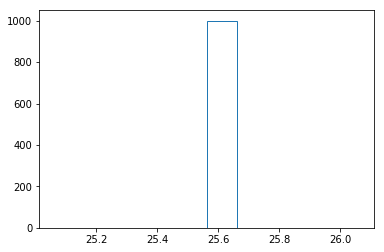

In [20]:
mc = bw.MonteCarloLCA({("stuffy", "widget"): 1}, a_method.name)
results = [next(mc) for _ in range(1000)]
plt.hist(results, histtype='step')

Using presampled values introduces uncertainty from the uncertain variables, and chain of formulas

(array([115., 112., 110.,  88., 107.,  92., 105.,  65., 132.,  74.]),
 array([23.34299911, 27.09372453, 30.84444996, 34.59517539, 38.34590081,
        42.09662624, 45.84735167, 49.59807709, 53.34880252, 57.09952794,
        60.85025337]),
 <a list of 1 Patch objects>)

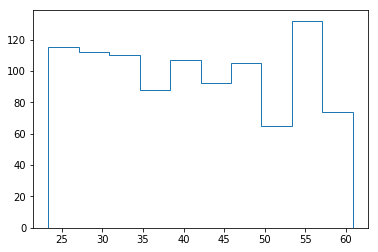

In [21]:
mc = bw.MonteCarloLCA({("stuffy", "widget"): 1}, a_method.name, presamples=[filepath])
results = [next(mc) for _ in range(1000)]
plt.hist(results, histtype="step")